In [1]:
import torch
import torch.nn as nn
from utils import v_wrap, set_init, push_and_pull, record
import torch.nn.functional as F
import torch.multiprocessing as mp
from shared_adam import SharedAdam
import gym
import os
os.environ["OMP_NUM_THREADS"] = "1"

UPDATE_GLOBAL_ITER = 10
GAMMA = 0.9
MAX_EP = 4000

env = gym.make('CartPole-v0')
N_S = env.observation_space.shape[0]
N_A = env.action_space.n

In [2]:
N_A

2

In [3]:
class Net(nn.Module):
    def __init__(self, s_dim, a_dim):
        super(Net, self).__init__()
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.pi1 = nn.Linear(s_dim, 200)
        self.pi2 = nn.Linear(200, a_dim)
        self.v1 = nn.Linear(s_dim, 100)
        self.v2 = nn.Linear(100, 1)
        set_init([self.pi1, self.pi2, self.v1, self.v2])
        self.distribution = torch.distributions.Categorical

    def forward(self, x):
        pi1 = F.relu6(self.pi1(x))
        logits = self.pi2(pi1)
        v1 = F.relu6(self.v1(x))
        values = self.v2(v1)
        return logits, values

    def choose_action(self, s):
        self.eval()
        logits, _ = self.forward(s)
        prob = F.softmax(logits, dim=1).data
        m = self.distribution(prob)
        return m.sample().numpy()[0]

    def loss_func(self, s, a, v_t):
        self.train()
        logits, values = self.forward(s)
        td = v_t - values
        c_loss = td.pow(2)
        
        probs = F.softmax(logits, dim=1)
        m = self.distribution(probs)
        exp_v = m.log_prob(a) * td.detach().squeeze()
        a_loss = -exp_v
        total_loss = (c_loss + a_loss).mean()
        return total_loss

In [4]:
class Worker(mp.Process):
    def __init__(self, gnet, opt, global_ep, global_ep_r, res_queue, name):
        super(Worker, self).__init__()
        self.name = 'w%i' % name
        self.g_ep, self.g_ep_r, self.res_queue = global_ep, global_ep_r, res_queue
        self.gnet, self.opt = gnet, opt
        self.lnet = Net(N_S, N_A)           # local network
        self.env = gym.make('CartPole-v0').unwrapped

    def run(self):
        total_step = 1
        while self.g_ep.value < MAX_EP:
            s = self.env.reset()
            buffer_s, buffer_a, buffer_r = [], [], []
            ep_r = 0.
            while True:
                if self.name == 'w0':
                    self.env.render()
                a = self.lnet.choose_action(v_wrap(s[None, :]))
                s_, r, done, _ = self.env.step(a)
                if done: r = -1
                ep_r += r
                buffer_a.append(a)
                buffer_s.append(s)
                buffer_r.append(r)

                if total_step % UPDATE_GLOBAL_ITER == 0 or done:  # update global and assign to local net
                    # sync
                    push_and_pull(self.opt, self.lnet, self.gnet, done, s_, buffer_s, buffer_a, buffer_r, GAMMA)
                    buffer_s, buffer_a, buffer_r = [], [], []

                    if done:  # done and print information
                        record(self.g_ep, self.g_ep_r, ep_r, self.res_queue, self.name)
                        break
                s = s_
                total_step += 1
        self.res_queue.put(None)

In [5]:
gnet = Net(N_S, N_A)        # global network
gnet.share_memory()         # share the global parameters in multiprocessing
opt = SharedAdam(gnet.parameters(), lr=0.0001)      # global optimizer
global_ep, global_ep_r, res_queue = mp.Value('i', 0), mp.Value('d', 0.), mp.Queue()

In [6]:
# parallel training
workers = [Worker(gnet, opt, global_ep, global_ep_r, res_queue, i) for i in range(mp.cpu_count())]
[w.start() for w in workers]
res = []                    # record episode reward to plot

w2 Ep: 1 | Ep_r: 7
w1 Ep: 2 | Ep_r: 7
w3 Ep: 3 | Ep_r: 7
w2 Ep: 4 | Ep_r: 7
w2 Ep: 5 | Ep_r: 7
w1 Ep: 6 | Ep_r: 7
w3 Ep: 7 | Ep_r: 7


Process w0:
Traceback (most recent call last):
  File "/home/aaron/anaconda3/envs/pytorch_env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<ipython-input-4-a8a8617973ed>", line 18, in run
    self.env.render()
  File "/home/aaron/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/gym/envs/classic_control/cartpole.py", line 150, in render
    from gym.envs.classic_control import rendering


w3 Ep: 8 | Ep_r: 7


  File "/home/aaron/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/gym/envs/classic_control/rendering.py", line 27, in <module>
    from pyglet.gl import *
  File "/home/aaron/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/pyglet/gl/__init__.py", line 221, in <module>
    from .xlib import XlibConfig as Config
  File "/home/aaron/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/pyglet/gl/xlib.py", line 12, in <module>
    from pyglet.canvas.xlib import XlibCanvas
  File "/home/aaron/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/pyglet/canvas/__init__.py", line 103, in <module>
    from pyglet.canvas.xlib import XlibDisplay as Display
  File "/home/aaron/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/pyglet/canvas/xlib.py", line 19, in <module>
    from . import xlib_vidmoderestore
  File "/home/aaron/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/pyglet/canvas/xlib_vidmoderestore.py", line 23, in <module>
    from pyglet.libs.x11 import xl

w1 Ep: 9 | Ep_r: 7
w3 Ep: 10 | Ep_r: 8
w2 Ep: 11 | Ep_r: 8
w1 Ep: 12 | Ep_r: 8
w3 Ep: 13 | Ep_r: 8
w4 Ep: 14 | Ep_r: 8
w2 Ep: 15 | Ep_r: 8
w3 Ep: 16 | Ep_r: 8
w1 Ep: 17 | Ep_r: 9
w2 Ep: 18 | Ep_r: 9
w4 Ep: 20 | Ep_r: 9
w3 Ep: 21 | Ep_r: 9
w5 Ep: 20 | Ep_r: 9
w1 Ep: 22 | Ep_r: 9
w2 Ep: 23 | Ep_r: 9
w3 Ep: 25 | Ep_r: 9
w5 Ep: 25 | Ep_r: 9
w4 Ep: 26 | Ep_r: 9
w6 Ep: 27 | Ep_r: 9
w2 Ep: 28 | Ep_r: 9
w1 Ep: 29 | Ep_r: 9
w5 Ep: 30 | Ep_r: 9
w3 Ep: 32 | Ep_r: 9
w4 Ep: 33 | Ep_r: 9
w7 Ep: 32 | Ep_r: 9
w6 Ep: 34 | Ep_r: 10
w2 Ep: 36 | Ep_r: 10
w8 Ep: 35 | Ep_r: 9
w1 Ep: 37 | Ep_r: 10
w4 Ep: 38 | Ep_r: 10
w9 Ep: 39 | Ep_r: 10
w6 Ep: 40 | Ep_r: 10
w5 Ep: 41 | Ep_r: 10
w2 Ep: 43 | Ep_r: 10
w3 Ep: 43 | Ep_r: 10
w8 Ep: 44 | Ep_r: 10
w7 Ep: 45 | Ep_r: 10
w1 Ep: 46 | Ep_r: 10
w5 Ep: 47 | Ep_r: 10
w4 Ep: 49 | Ep_r: 10
w3 Ep: 48 | Ep_r: 10
w6 Ep: 50 | Ep_r: 10
w2 Ep: 51 | Ep_r: 10
w9 Ep: 52 | Ep_r: 10
w8 Ep: 53 | Ep_r: 11
w7 Ep: 55 | Ep_r: 11
w10 Ep: 54 | Ep_r: 11
w1 Ep: 56 | Ep_r: 11
w5 Ep: 57 | Ep_r: 

w9 Ep: 377 | Ep_r: 17
w25 Ep: 385 | Ep_r: 17
w27 Ep: 383 | Ep_r: 17
w10 Ep: 382 | Ep_r: 17
w31 Ep: 379 | Ep_r: 17
w21 Ep: 380 | Ep_r: 17
w7 Ep: 381 | Ep_r: 17
w5 Ep: 387 | Ep_r: 17
w30 Ep: 384 | Ep_r: 17
w13 Ep: 389 | Ep_r: 17
w19 Ep: 390 | Ep_r: 17
w2 Ep: 388 | Ep_r: 17
w15 Ep: 394 | Ep_r: 17
w29 Ep: 392 | Ep_r: 17
w8 Ep: 394 | Ep_r: 17
w6 Ep: 392 | Ep_r: 17
w28 Ep: 386 | Ep_r: 17
w12 Ep: 397 | Ep_r: 17
w22 Ep: 396 | Ep_r: 17
w17 Ep: 400 | Ep_r: 17
w20 Ep: 401 | Ep_r: 17
w3 Ep: 395 | Ep_r: 17
w11 Ep: 399 | Ep_r: 17
w18 Ep: 403 | Ep_r: 17
w10 Ep: 405 | Ep_r: 17
w23 Ep: 402 | Ep_r: 17
w2 Ep: 406 | Ep_r: 17
w26 Ep: 408 | Ep_r: 17
w24 Ep: 407 | Ep_r: 17
w4 Ep: 409 | Ep_r: 17
w1 Ep: 411 | Ep_r: 17
w30 Ep: 410 | Ep_r: 17
w7 Ep: 413 | Ep_r: 17
w16 Ep: 398 | Ep_r: 17
w27 Ep: 405 | Ep_r: 17
w25 Ep: 415 | Ep_r: 17
w21 Ep: 414 | Ep_r: 17
w14 Ep: 416 | Ep_r: 17
w20 Ep: 417 | Ep_r: 17
w29 Ep: 420 | Ep_r: 17
w9 Ep: 412 | Ep_r: 17
w3 Ep: 419 | Ep_r: 17
w19 Ep: 422 | Ep_r: 17
w28 Ep: 421 | Ep_r: 17
w

w22 Ep: 743 | Ep_r: 18
w27 Ep: 740 | Ep_r: 18
w7 Ep: 735 | Ep_r: 17
w26 Ep: 746 | Ep_r: 18
w2 Ep: 745 | Ep_r: 18
w4 Ep: 742 | Ep_r: 18
w6 Ep: 729 | Ep_r: 17
w19 Ep: 749 | Ep_r: 18
w23 Ep: 744 | Ep_r: 18
w31 Ep: 750 | Ep_r: 18
w13 Ep: 751 | Ep_r: 19
w25 Ep: 747 | Ep_r: 18
w12 Ep: 753 | Ep_r: 19
w28 Ep: 748 | Ep_r: 18
w20 Ep: 754 | Ep_r: 19
w24 Ep: 756 | Ep_r: 19
w3 Ep: 757 | Ep_r: 19
w16 Ep: 752 | Ep_r: 19
w17 Ep: 755 | Ep_r: 19
w14 Ep: 759 | Ep_r: 19
w11 Ep: 760 | Ep_r: 19
w10 Ep: 762 | Ep_r: 19
w30 Ep: 761 | Ep_r: 19
w1 Ep: 758 | Ep_r: 19
w7 Ep: 764 | Ep_r: 19
w5 Ep: 767 | Ep_r: 19
w18 Ep: 765 | Ep_r: 19
w27 Ep: 763 | Ep_r: 19
w21 Ep: 766 | Ep_r: 19
w9 Ep: 769 | Ep_r: 19
w26 Ep: 771 | Ep_r: 19
w12 Ep: 773 | Ep_r: 19
w29 Ep: 770 | Ep_r: 19
w31 Ep: 774 | Ep_r: 19
w22 Ep: 775 | Ep_r: 19
w8 Ep: 768 | Ep_r: 19
w25 Ep: 777 | Ep_r: 19
w23 Ep: 773 | Ep_r: 19
w20 Ep: 779 | Ep_r: 20
w3 Ep: 780 | Ep_r: 20
w15 Ep: 781 | Ep_r: 20
w17 Ep: 784 | Ep_r: 20
w13 Ep: 782 | Ep_r: 20
w30 Ep: 783 | Ep_r: 20

w24 Ep: 1090 | Ep_r: 21
w4 Ep: 1094 | Ep_r: 21
w26 Ep: 1095 | Ep_r: 21
w15 Ep: 1102 | Ep_r: 21
w22 Ep: 1100 | Ep_r: 21
w1 Ep: 1099 | Ep_r: 21
w3 Ep: 1108 | Ep_r: 21
w23 Ep: 1106 | Ep_r: 21
w20 Ep: 1111 | Ep_r: 21
w19 Ep: 1104 | Ep_r: 21
w29 Ep: 1106 | Ep_r: 21
w30 Ep: 1103 | Ep_r: 21
w21 Ep: 1110 | Ep_r: 21
w17 Ep: 1110 | Ep_r: 21
w18 Ep: 1113 | Ep_r: 21
w14 Ep: 1107 | Ep_r: 21
w7 Ep: 1101 | Ep_r: 21
w13 Ep: 1112 | Ep_r: 21
w31 Ep: 1115 | Ep_r: 21
w9 Ep: 1114 | Ep_r: 21
w21 Ep: 1116 | Ep_r: 21
w1 Ep: 1118 | Ep_r: 21
w6 Ep: 1119 | Ep_r: 21
w16 Ep: 1124 | Ep_r: 21
w11 Ep: 1124 | Ep_r: 21
w22 Ep: 1122 | Ep_r: 21
w15 Ep: 1128 | Ep_r: 21
w12 Ep: 1127 | Ep_r: 21
w4 Ep: 1127 | Ep_r: 21
w27 Ep: 1126 | Ep_r: 21
w20 Ep: 1126 | Ep_r: 21
w8 Ep: 1129 | Ep_r: 21
w24 Ep: 1117 | Ep_r: 21
w2 Ep: 1130 | Ep_r: 21
w18 Ep: 1131 | Ep_r: 21
w10 Ep: 1120 | Ep_r: 21
w3 Ep: 1133 | Ep_r: 21
w13 Ep: 1135 | Ep_r: 21
w25 Ep: 1136 | Ep_r: 21
w26 Ep: 1132 | Ep_r: 21
w7 Ep: 1137 | Ep_r: 22
w29 Ep: 1140 | Ep_r: 22
w30 

w14 Ep: 1440 | Ep_r: 38
w6 Ep: 1444 | Ep_r: 38
w8 Ep: 1443 | Ep_r: 38
w19 Ep: 1446 | Ep_r: 38
w11 Ep: 1447 | Ep_r: 38
w31 Ep: 1448 | Ep_r: 38
w24 Ep: 1445 | Ep_r: 38
w20 Ep: 1449 | Ep_r: 39
w9 Ep: 1454 | Ep_r: 40
w5 Ep: 1452 | Ep_r: 39
w2 Ep: 1451 | Ep_r: 39
w21 Ep: 1455 | Ep_r: 40
w12 Ep: 1450 | Ep_r: 39
w14 Ep: 1460 | Ep_r: 40
w30 Ep: 1462 | Ep_r: 40
w8 Ep: 1456 | Ep_r: 40
w17 Ep: 1453 | Ep_r: 40
w29 Ep: 1458 | Ep_r: 40
w19 Ep: 1466 | Ep_r: 41
w27 Ep: 1457 | Ep_r: 40
w15 Ep: 1466 | Ep_r: 41
w28 Ep: 1459 | Ep_r: 40
w26 Ep: 1464 | Ep_r: 41
w16 Ep: 1467 | Ep_r: 41
w7 Ep: 1461 | Ep_r: 40
w25 Ep: 1463 | Ep_r: 41
w13 Ep: 1470 | Ep_r: 42
w4 Ep: 1469 | Ep_r: 41
w10 Ep: 1468 | Ep_r: 41
w11 Ep: 1471 | Ep_r: 41
w23 Ep: 1472 | Ep_r: 42
w21 Ep: 1475 | Ep_r: 42
w1 Ep: 1473 | Ep_r: 42
w22 Ep: 1474 | Ep_r: 42
w2 Ep: 1476 | Ep_r: 42
w6 Ep: 1477 | Ep_r: 42
w30 Ep: 1479 | Ep_r: 42
w24 Ep: 1480 | Ep_r: 42
w3 Ep: 1478 | Ep_r: 42
w18 Ep: 1483 | Ep_r: 42
w29 Ep: 1485 | Ep_r: 42
w9 Ep: 1487 | Ep_r: 42
w5 Ep

w30 Ep: 1769 | Ep_r: 12
w17 Ep: 1785 | Ep_r: 11
w2 Ep: 1792 | Ep_r: 11
w1 Ep: 1791 | Ep_r: 11
w11 Ep: 1795 | Ep_r: 11
w18 Ep: 1798 | Ep_r: 11
w6 Ep: 1789 | Ep_r: 11
w10 Ep: 1798 | Ep_r: 11
w5 Ep: 1802 | Ep_r: 11
w3 Ep: 1794 | Ep_r: 11
w12 Ep: 1796 | Ep_r: 11
w31 Ep: 1799 | Ep_r: 11
w20 Ep: 1800 | Ep_r: 11
w19 Ep: 1801 | Ep_r: 11
w23 Ep: 1793 | Ep_r: 11
w15 Ep: 1808 | Ep_r: 10
w13 Ep: 1807 | Ep_r: 11
w8 Ep: 1807 | Ep_r: 11
w24 Ep: 1804 | Ep_r: 11
w25 Ep: 1805 | Ep_r: 11
w14 Ep: 1803 | Ep_r: 11
w26 Ep: 1811 | Ep_r: 10
w2 Ep: 1813 | Ep_r: 10
w4 Ep: 1814 | Ep_r: 10
w6 Ep: 1815 | Ep_r: 10
w5 Ep: 1819 | Ep_r: 10
w27 Ep: 1818 | Ep_r: 10
w11 Ep: 1818 | Ep_r: 10
w16 Ep: 1809 | Ep_r: 10
w28 Ep: 1810 | Ep_r: 10
w30 Ep: 1822 | Ep_r: 10
w31 Ep: 1824 | Ep_r: 10
w20 Ep: 1823 | Ep_r: 10
w22 Ep: 1821 | Ep_r: 10
w18 Ep: 1825 | Ep_r: 10
w1 Ep: 1827 | Ep_r: 10
w10 Ep: 1820 | Ep_r: 10
w17 Ep: 1814 | Ep_r: 10
w26 Ep: 1828 | Ep_r: 10
w7 Ep: 1832 | Ep_r: 10
w9 Ep: 1830 | Ep_r: 10
w19 Ep: 1826 | Ep_r: 10
w23 E

w27 Ep: 2147 | Ep_r: 7
w7 Ep: 2148 | Ep_r: 7
w18 Ep: 2157 | Ep_r: 7
w5 Ep: 2151 | Ep_r: 7
w22 Ep: 2149 | Ep_r: 7
w11 Ep: 2150 | Ep_r: 7
w25 Ep: 2154 | Ep_r: 7
w10 Ep: 2152 | Ep_r: 7
w15 Ep: 2153 | Ep_r: 7
w12 Ep: 2157 | Ep_r: 7
w14 Ep: 2160 | Ep_r: 7
w30 Ep: 2158 | Ep_r: 7
w9 Ep: 2161 | Ep_r: 7
w13 Ep: 2162 | Ep_r: 7
w4 Ep: 2155 | Ep_r: 7
w23 Ep: 2164 | Ep_r: 7
w1 Ep: 2168 | Ep_r: 7
w20 Ep: 2167 | Ep_r: 7
w6 Ep: 2159 | Ep_r: 7
w16 Ep: 2169 | Ep_r: 7
w19 Ep: 2163 | Ep_r: 7
w29 Ep: 2166 | Ep_r: 7
w24 Ep: 2165 | Ep_r: 7
w10 Ep: 2174 | Ep_r: 7
w25 Ep: 2178 | Ep_r: 7
w2 Ep: 2172 | Ep_r: 7
w8 Ep: 2178 | Ep_r: 7
w7 Ep: 2170 | Ep_r: 7
w21 Ep: 2176 | Ep_r: 7
w22 Ep: 2180 | Ep_r: 7
w31 Ep: 2179 | Ep_r: 7
w28 Ep: 2175 | Ep_r: 7
w5 Ep: 2181 | Ep_r: 7
w27 Ep: 2186 | Ep_r: 7
w26 Ep: 2173 | Ep_r: 7
w17 Ep: 2182 | Ep_r: 7
w18 Ep: 2185 | Ep_r: 7
w9 Ep: 2187 | Ep_r: 7
w30 Ep: 2185 | Ep_r: 7
w3 Ep: 2171 | Ep_r: 7
w11 Ep: 2183 | Ep_r: 7
w23 Ep: 2188 | Ep_r: 7
w29 Ep: 2189 | Ep_r: 7
w12 Ep: 2190 | Ep_r: 7


w9 Ep: 2512 | Ep_r: 7
w8 Ep: 2510 | Ep_r: 7
w30 Ep: 2509 | Ep_r: 7
w24 Ep: 2516 | Ep_r: 7
w12 Ep: 2515 | Ep_r: 7
w20 Ep: 2508 | Ep_r: 7
w31 Ep: 2515 | Ep_r: 7
w2 Ep: 2511 | Ep_r: 7
w18 Ep: 2515 | Ep_r: 7
w22 Ep: 2517 | Ep_r: 7
w28 Ep: 2523 | Ep_r: 7
w11 Ep: 2526 | Ep_r: 7
w26 Ep: 2519 | Ep_r: 7
w6 Ep: 2522 | Ep_r: 7
w7 Ep: 2518 | Ep_r: 7
w10 Ep: 2526 | Ep_r: 7
w25 Ep: 2520 | Ep_r: 7
w3 Ep: 2522 | Ep_r: 7
w29 Ep: 2534 | Ep_r: 7
w13 Ep: 2527 | Ep_r: 7
w5 Ep: 2526 | Ep_r: 7
w27 Ep: 2531 | Ep_r: 7
w23 Ep: 2535 | Ep_r: 7
w15 Ep: 2529 | Ep_r: 7
w16 Ep: 2536 | Ep_r: 7
w19 Ep: 2528 | Ep_r: 7
w21 Ep: 2533 | Ep_r: 7
w4 Ep: 2532 | Ep_r: 7
w17 Ep: 2530 | Ep_r: 7
w14 Ep: 2537 | Ep_r: 7
w9 Ep: 2545 | Ep_r: 7
w20 Ep: 2542 | Ep_r: 7
w8 Ep: 2538 | Ep_r: 7
w31 Ep: 2539 | Ep_r: 7
w24 Ep: 2542 | Ep_r: 7
w30 Ep: 2540 | Ep_r: 7
w2 Ep: 2543 | Ep_r: 7
w1 Ep: 2545 | Ep_r: 7
w22 Ep: 2550 | Ep_r: 7
w12 Ep: 2549 | Ep_r: 7
w7 Ep: 2547 | Ep_r: 7
w18 Ep: 2548 | Ep_r: 7
w5 Ep: 2552 | Ep_r: 7
w23 Ep: 2553 | Ep_r: 7
w1

w7 Ep: 2871 | Ep_r: 7
w17 Ep: 2844 | Ep_r: 7
w11 Ep: 2872 | Ep_r: 7
w19 Ep: 2873 | Ep_r: 7
w4 Ep: 2876 | Ep_r: 7
w13 Ep: 2876 | Ep_r: 7
w5 Ep: 2876 | Ep_r: 7
w22 Ep: 2877 | Ep_r: 7
w6 Ep: 2878 | Ep_r: 7
w26 Ep: 2880 | Ep_r: 7
w28 Ep: 2882 | Ep_r: 7
w24 Ep: 2864 | Ep_r: 7
w10 Ep: 2883 | Ep_r: 7
w29 Ep: 2879 | Ep_r: 7
w31 Ep: 2886 | Ep_r: 7
w1 Ep: 2886 | Ep_r: 7
w15 Ep: 2884 | Ep_r: 7
w30 Ep: 2891 | Ep_r: 7
w21 Ep: 2881 | Ep_r: 7
w14 Ep: 2889 | Ep_r: 7
w3 Ep: 2892 | Ep_r: 7
w20 Ep: 2893 | Ep_r: 7
w23 Ep: 2898 | Ep_r: 7
w13 Ep: 2900 | Ep_r: 7
w7 Ep: 2895 | Ep_r: 7
w16 Ep: 2887 | Ep_r: 7
w18 Ep: 2898 | Ep_r: 7
w2 Ep: 2900 | Ep_r: 7
w8 Ep: 2894 | Ep_r: 7
w4 Ep: 2901 | Ep_r: 7
w19 Ep: 2902 | Ep_r: 7
w6 Ep: 2898 | Ep_r: 7
w27 Ep: 2903 | Ep_r: 7
w9 Ep: 2889 | Ep_r: 7
w12 Ep: 2891 | Ep_r: 7
w29 Ep: 2906 | Ep_r: 7
w26 Ep: 2906 | Ep_r: 7
w25 Ep: 2904 | Ep_r: 7
w11 Ep: 2908 | Ep_r: 7
w7 Ep: 2911 | Ep_r: 7
w10 Ep: 2909 | Ep_r: 7
w22 Ep: 2910 | Ep_r: 7
w28 Ep: 2907 | Ep_r: 7
w21 Ep: 2913 | Ep_r: 7
w

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
while True:
    r = res_queue.get()
    if r is not None:
        res.append(r)
    else:
        break
[w.join() for w in workers]

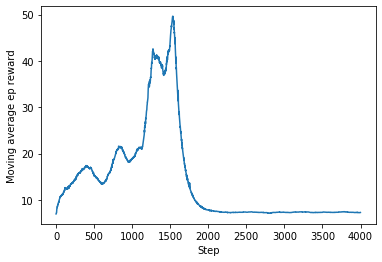

In [8]:
import matplotlib.pyplot as plt
plt.plot(res)
plt.ylabel('Moving average ep reward')
plt.xlabel('Step')
plt.show()